In [1]:
import numpy as np
import pandas as pd
import os
from scipy.stats import linregress
from multiprocessing import Pool
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time

def mean_squared_displacement_optimised(file_path):
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    x_smooth = np.array(data['x_smooth'])
    y_smooth = np.array(data['y_smooth'])
    z_smooth = np.array(data['z_smooth'])
    time = np.array(data['time'])
    
    msd_by_tau = {}

    for tau in range(1, len(time)):
        
        dx = x_smooth[tau:] - x_smooth[:-tau]
        dy = y_smooth[tau:] - y_smooth[:-tau]
        dz = z_smooth[tau:] - z_smooth[:-tau]
        squared_displacements = dx**2 + dy**2 + dz**2
        msd_by_tau[round(time[tau] - time[0], 3)] = np.mean(squared_displacements)

    return msd_by_tau

def find_gradient_intercept(file_path):
    msd_by_tau = mean_squared_displacement_optimised(file_path)
    
    tau_arr = np.array(list(msd_by_tau.keys()))
    msd_arr = np.array(list(msd_by_tau.values()))
    
    tau_max = tau_arr.max()
    tau_limit = tau_max / 20
    mask = tau_arr <= tau_limit
    
    limited_tau = tau_arr[mask]
    limited_msd = msd_arr[mask]
    
    log_tau = np.log(limited_tau)
    log_msd = np.log(limited_msd)
    
    try:
        slope, intercept, r_value, p_value, _ = linregress(log_tau, log_msd)
        return slope, intercept, r_value, p_value
    except ValueError:
        return np.nan, np.nan, np.nan, np.nan



2.0.3


In [88]:
msd_by_tau = mean_squared_displacement_optimised('FINALDATA/Split_Data/WT/nonswimmingWT/_track12474_0_processed.txt')

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# split data 
tau_arr = np.array(list(msd_by_tau.keys()))
msd_arr = np.array(list(msd_by_tau.values()))

#logs of tau and MSD
log_tau = np.log(tau_arr)
log_msd = np.log(msd_arr)

# Determine the cutoff for up to a 20th of tau max
cutoff_index = np.where(tau_arr <= 0.05 * tau_arr.max())[0]


subset_log_tau = log_tau[cutoff_index]
subset_log_msd = log_msd[cutoff_index]
#find grad
slope, intercept, r_value, p_value, std_err = linregress(subset_log_tau, subset_log_msd)

#create fit line
regression_line = slope * subset_log_tau + intercept

#plot the data and regression line
plt.figure(figsize=(8, 6))
plt.scatter(log_tau, log_msd, label='Data', alpha=0.7)
plt.plot(subset_log_tau, regression_line, color='red', label=f'Fit: y={slope:.2f}x + {intercept:.2f}')
plt.xlabel('ln(Tau)')
plt.ylabel('ln(MSD)')
plt.title('Log-log plot with Linear Regression')
plt.grid()
plt.legend()
#plt.savefig('FINALDATA/Plots/msd vs tau example')
plt.show()

    


NameError: name 'msd_by_tau' is not defined

In [85]:

find_gradient_intercept(file_path)

(1.4017630004422978, 2.363560826076201)

In [2]:

def process_directory_1(directory_path):
    #FIND ALL FILES IN DIRECTORY 
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    results = []
    #loop all files to find slope intercept r and p 
    for file_path in files:
        slope, intercept, r_value, p_value = find_gradient_intercept(file_path)
        results.append([slope, intercept, r_value, p_value])  # Append the results as a list
    
    results_array = np.array(results)  # Convert the list of lists into a 4D array

    return results_array


In [4]:
results = process_directory_1('FINALDATA/RAW/WT_planktonic_final/')


/Users/ethanbrentnall/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/ethanbrentnall/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/ethanbrentnall/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/Users/ethanbrentnall/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/ethanbrentnall/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r 

In [12]:
df = pd.DataFrame(results, columns=['Slope', 'Intercept', 'R_Value', 'P_Value'])
len(df)

27152

In [13]:
df

,Slope,Intercept,R_Value,P_Value
0,1.838983,4.258117,0.999803,2.814695e-286
1,2.857312,10.910567,0.992193,5.600630e-15
2,1.968795,6.815519,0.999977,8.624517e-130
3,2.423108,9.290501,0.996798,3.323254e-21
4,1.998964,7.941405,1.000000,6.665426e-24
...,...,...,...,...
27147,1.979049,7.266466,0.999993,2.751340e-108
27148,1.991386,8.001620,0.999998,3.411377e-145
27149,2.000255,8.879851,1.000000,1.011377e-51
27150,1.993444,8.021269,0.999999,4.983839e-91


In [36]:
low_R = df[df['R_Value'] < 0.95]  # Filter rows where R_Value is 0
relevant_gradients = low_R['Slope']  # Select the 'Slope' column

print("Relevant gradients for R values equal to 0:")
print(len(relevant_gradients))

Relevant gradients for R values equal to 0:
47


0.0


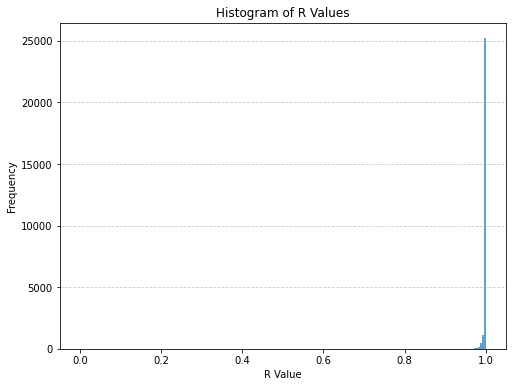

In [23]:
print(min(df['R_Value']))
plt.figure(figsize=(8, 6))
plt.hist(df['R_Value'], bins=200, alpha=0.7)
plt.title("Histogram of R Values")
plt.xlabel("R Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [153]:
import numpy as np

def save_to_txt(array, filename):
    np.savetxt(filename, array, delimiter=' ', header='Gradient Intercept', comments='')
save_to_txt(results, 'FINALDATA/Parameters/gradients_and_intercepts.txt')

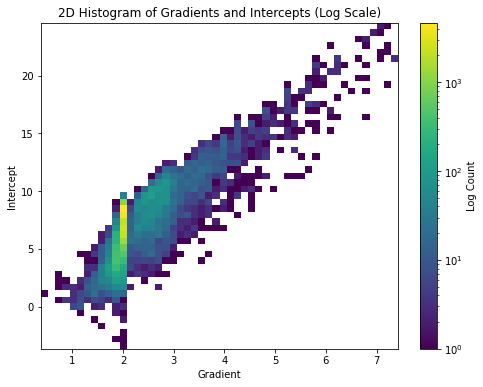

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_2d_histogram(array):
    gradients = array[:, 0]  # First column: gradients
    intercepts = array[:, 1]  # Second column: intercepts

    plt.figure(figsize=(8, 6))
    plt.hist2d(gradients, intercepts, bins=50, cmap='viridis', norm=LogNorm())
    plt.colorbar(label='Log Count')  # Color bar to show frequency in log scale
    plt.xlabel('Gradient')
    plt.ylabel('Intercept')
    plt.title('2D Histogram of Gradients and Intercepts (Log Scale)')
    plt.savefig('FINALDATA/Plots/2D_hist_flat_new')
    plt.show()


plot_2d_histogram(filtered_results)



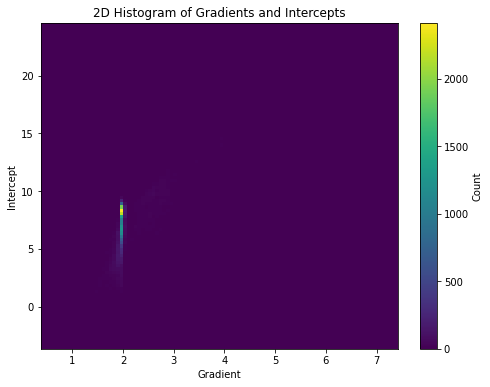

In [10]:
def plot_2d_histogram(array):
    gradients = array[:, 0]  # First column: gradients
    intercepts = array[:, 1]  # Second column: intercepts

    plt.figure(figsize=(8, 6))
    plt.hist2d(gradients, intercepts, bins=100, cmap='viridis')
    plt.colorbar(label='Count')  # Color bar to show frequency
    plt.xlabel('Gradient')
    plt.ylabel('Intercept')
    plt.title('2D Histogram of Gradients and Intercepts')
    #plt.savefig('FINALDATA/Plots/2D Histogram of Gradients and Intercepts')
    plt.show()


plot_2d_histogram(filtered_results)


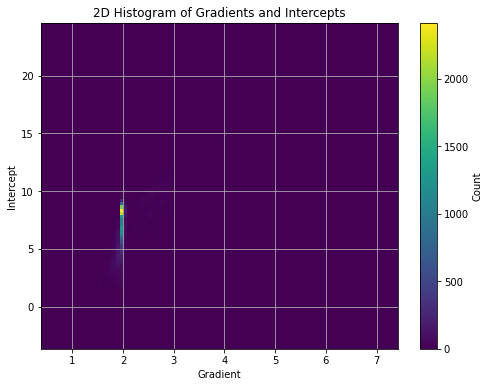

In [9]:
# Check and filter out NaN values
valid_indices = ~np.isnan(results[:, 0]) & ~np.isnan(results[:, 1])
filtered_results = results[valid_indices]

# Extract gradients and intercepts from the filtered results
gradients = filtered_results[:, 0]
intercepts = filtered_results[:, 1]

# Plot the 2D histogram
plt.figure(figsize=(8, 6))
plt.hist2d(gradients, intercepts, bins=100, cmap='viridis')
plt.colorbar(label='Count')  # Color bar to show frequency
plt.xlabel('Gradient')
plt.ylabel('Intercept')
plt.title('2D Histogram of Gradients and Intercepts')
plt.grid()
plt.show()


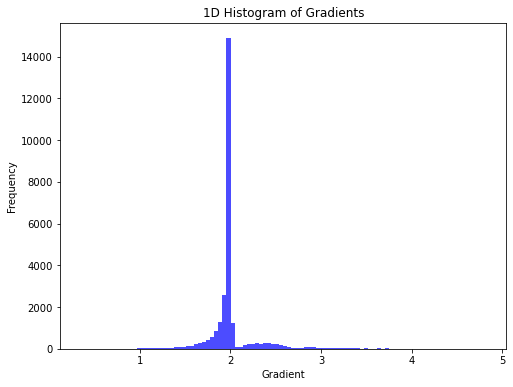

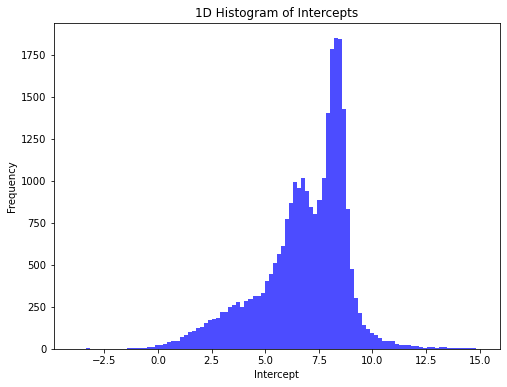

In [100]:
import numpy as np
import matplotlib.pyplot as plt

def plot_1d_histogram(array):
    intercepts = array[:, 1]  # First column: gradients

    plt.figure(figsize=(8, 6))
    plt.hist(intercepts, bins=100, color='blue', alpha=0.7)
    plt.xlabel('Intercept')
    plt.ylabel('Frequency')
    plt.title('1D Histogram of Intercepts')
    plt.show()


plot_1d_histogram(results)


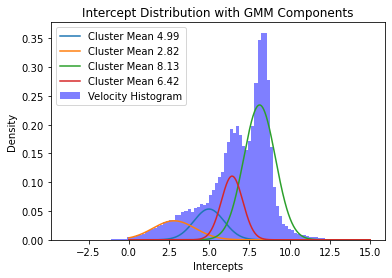

In [101]:
from sklearn.mixture import GaussianMixture


intercepts = results[:, 1]

# Fit a Gaussian Mixture Model
n_components = 4 # numer of gaussians 
gmm = GaussianMixture(n_components=n_components)
gmm.fit(intercepts.reshape(-1, 1))

# Get the mean and standard deviation of each Gaussian 
means = gmm.means_.flatten()
std_devs = np.sqrt(gmm.covariances_).flatten()
weights = gmm.weights_

# Plot histogram of velocities
plt.hist(intercepts, bins=100, density=True, alpha=0.5, color='blue', label='Velocity Histogram')

# Overlay with Gaussians
x = np.linspace(0, max(intercepts), 1000)
for mean, std, weight in zip(means, std_devs, weights):
    plt.plot(x, weight * np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi)), label=f'Cluster Mean {mean:.2f}')

plt.xlabel('Intercepts')
plt.ylabel('Density')
plt.title('Intercept Distribution with GMM Components')
plt.savefig('FINALDATA/Plots/GMM intercepts')
plt.legend()
plt.show()

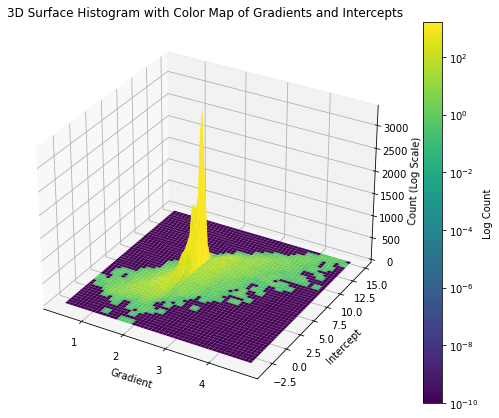

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_histogram_with_colormap(array):
    gradients = array[:, 0]
    intercepts = array[:, 1]

    # Compute 2D histogram and replace zero values to allow LogNorm
    hist, xedges, yedges = np.histogram2d(gradients, intercepts, bins=50)
    hist[hist == 0] = 1e-10  # Small constant to handle log scale

    # Create meshgrid for plotting
    x_centers = (xedges[1:] + xedges[:-1]) / 2
    y_centers = (yedges[1:] + yedges[:-1]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)

    # Plot 3D surface with color map based on log-scaled count
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, hist.T, cmap='viridis', norm=LogNorm(), edgecolor='none')

    # Color bar to show counts
    fig.colorbar(surf, label='Log Count')

    # Labels
    ax.set_xlabel('Gradient')
    ax.set_ylabel('Intercept')
    ax.set_zlabel('Count (Log Scale)')
    plt.title('3D Surface Histogram with Color Map of Gradients and Intercepts')
    plt.show()


plot_3d_histogram_with_colormap(results)


In [156]:
import numpy as np
import plotly.graph_objects as go

def plot_3d_histogram_with_plotly(array):
    # Filter the data to include only the range for gradients and intercepts
    gradients = array[:, 0]
    intercepts = array[:, 1]

    # Apply the filtering based on ranges
    filtered_data = array[(gradients >= 0.8) & (intercepts >= 4)]

    # Extract the filtered gradients and intercepts
    gradients_filtered = filtered_data[:, 0]
    intercepts_filtered = filtered_data[:, 1]

    # Compute the 2D histogram with the filtered data
    hist, xedges, yedges = np.histogram2d(gradients_filtered, intercepts_filtered, bins=100)
    x_centers = (xedges[1:] + xedges[:-1]) / 2
    y_centers = (yedges[1:] + yedges[:-1]) / 2

    # Create surface plot
    fig = go.Figure(data=[go.Surface(
        z=hist.T,
        x=x_centers,
        y=y_centers,
        colorscale='Viridis',
        colorbar=dict(title="Count"),
        reversescale=True)])

    # Update layout
    fig.update_layout(
        width=1200,
        height=800,
        title="3D Histogram of Gradients and Intercepts",
        scene=dict(
            xaxis_title="Gradient",
            yaxis_title="Intercept",
            zaxis_title="Count"
        )
    )
    fig.show()


plot_3d_histogram_with_plotly(results)



In [133]:


def plot_3d_histogram_with_log_scale(array):
    # Filter data based on the specified range
    
    gradients = array[:, 0]
    intercepts = array[:, 1]

    # Compute 2D histogram
    hist, xedges, yedges = np.histogram2d(gradients, intercepts, bins=100)
    
    # Log-transform the histogram counts and set zero-counts to NaN
    hist = np.log10(hist + 1e-10)  # Add small constant for log stability
    hist[hist == -10] = np.nan  # Set zero counts to NaN to exclude them

    # Create meshgrid for centers of bins
    x_centers = (xedges[1:] + xedges[:-1]) / 2
    y_centers = (yedges[1:] + yedges[:-1]) / 2

    # Plot with Plotly
    fig = go.Figure(data=[go.Surface(
        z=hist.T,
        x=x_centers,
        y=y_centers,
        colorscale='Viridis',
        colorbar=dict(title="Log Count"),
        reversescale=True)])

    # Layout update
    fig.update_layout(
        width=1200,  # Increase width
        height=800,  # Increase height
        title="3D Histogram of Filtered Gradients and Intercepts with Log Color Scale",
        scene=dict(
            xaxis_title="Gradient",
            yaxis_title="Intercept",
            zaxis_title="Log Count"
        )
    )
    fig.show()


plot_3d_histogram_with_log_scale(results)


# Separating motile form the rest

In [13]:
import shutil
def sort_directory(directory_path, output_base):
    # Create output directories in FINALDATA
    in_range_dir = os.path.join(output_base, "ES")
    out_range_dir = os.path.join(output_base, "ENS")
    os.makedirs(in_range_dir, exist_ok=True)
    os.makedirs(out_range_dir, exist_ok=True)
    
    # Get all text files in directory
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    for file_path in files:
        # Calculate slope and intercept
        slope, intercept = find_gradient_intercept(file_path)
        
        # Determine target directory based on slope range
        if 1.75 <= slope <= 2.1:
            target_dir = in_range_dir
        else:
            target_dir = out_range_dir
        
        # Copy the file to the right directory
        shutil.copy(file_path, target_dir)

    print(f"Tracks with slope 1.75 - 2.1 copied to {in_range_dir}")
    print(f"All other tracks copied to {out_range_dir}")


In [14]:
wt_planktonic_path = "FINALDATA/RAW/evolved_planktonic_final/"
output_base = "FINALDATA/Grad_split/"
sort_directory(wt_planktonic_path, output_base)

<ipython-input-10-332e36b9b82f>:49: RuntimeWarning: divide by zero encountered in log
  log_msd = np.log(limited_msd)


Tracks with slope 1.75 - 2.1 copied to FINALDATA/Grad_split/ES
All other tracks copied to FINALDATA/Grad_split/ENS


In [27]:
def get_directory_length(directory_path):
    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    # Return the number of files
    return len(files)

directory_path = 'FINALDATA/tracks_out_range//'
get_directory_length(directory_path)

6173

In [28]:
def process_and_sort_directory(directory_path, output_base):
    # Create output directories in FINALDATA
    in_range_dir = os.path.join(output_base, "tracks_in_range")
    out_range_dir = os.path.join(output_base, "tracks_out_range")
    os.makedirs(in_range_dir, exist_ok=True)
    os.makedirs(out_range_dir, exist_ok=True)
    
    # Prepare a list to store slopes and intercepts for each file
    results = []
    
    # Get all text files in WT_planktonic
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    for file_path in files:
        # Calculate slope and intercept
        slope, intercept = find_gradient_intercept(file_path)
        
        # Append the slope and intercept to results
        results.append([slope, intercept])
        
        # Determine target directory based on slope range
        if 1.75 <= slope <= 2.1:
            target_dir = in_range_dir
        else:
            target_dir = out_range_dir
        
        # Copy the file to the directory
        shutil.copy(file_path, target_dir)
    
    # Convert results list to a 2D NumPy array 
    results_array = np.array(results)
    
    print(f"Tracks with slope 1.75 - 2.25 copied to {in_range_dir}")
    print(f"All other tracks copied to {out_range_dir}")
    
    return results_array 

In [29]:
directory_path = "FINALDATA/evolved_planktonic_final/"
output_base = "FINALDATA/Split Data/Evolved"
results_array = process_and_sort_directory(directory_path, output_base)

<ipython-input-3-cd1e0c25b0c0>:39: RuntimeWarning:

divide by zero encountered in log

/Users/ethanbrentnall/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning:

invalid value encountered in subtract



Tracks with slope 1.75 - 2.25 copied to FINALDATA/Split Data/Evolved/tracks_in_range
All other tracks copied to FINALDATA/Split Data/Evolved/tracks_out_range


In [32]:
directory_path = 'FINALDATA/Split Data/Evolved/non_swimming_evolved'
get_directory_length(directory_path)

37426

In [33]:
results_evolved = process_directory_1('FINALDATA/evolved_planktonic_final/')

<ipython-input-3-cd1e0c25b0c0>:39: RuntimeWarning:

divide by zero encountered in log

/Users/ethanbrentnall/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning:

invalid value encountered in subtract



In [35]:
plot_3d_histogram_with_plotly(results_evolved)

In [36]:
directory_path = "FINALDATA/evolved+disk_planktonic_final/"
output_base = "FINALDATA/Split Data/Evolved+disk"
results_evolved_disk = process_and_sort_directory(directory_path, output_base)

<ipython-input-3-cd1e0c25b0c0>:39: RuntimeWarning:

divide by zero encountered in log

/Users/ethanbrentnall/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning:

invalid value encountered in subtract



Tracks with slope 1.75 - 2.25 copied to FINALDATA/Split Data/Evolved+disk/tracks_in_range
All other tracks copied to FINALDATA/Split Data/Evolved+disk/tracks_out_range


In [38]:
len(results_evolved_disk)

36150

In [40]:
plot_3d_histogram_with_plotly(results_evolved_disk)

In [43]:
WT_non_smimming_results = process_directory_1('FINALDATA/Split_Data/WT/non_swimming_WT/')

In [44]:
plot_3d_histogram_with_plotly(WT_non_smimming_results)

In [45]:
WT_swimming_results = process_directory_1('FINALDATA/Split_Data/WT/swimming_WT/')

In [46]:
plot_3d_histogram_with_plotly(WT_swimming_results)

In [71]:
msd = mean_squared_displacement_optimised('FINALDATA/Split_Data/WT/swimming_WT/track128483_0_processed.txt')

In [35]:
import shutil
def sort_directory(directory_path, output_base):
    # Create output directories in FINALDATA
    in_range_dir = os.path.join(output_base, "swimmingED")
    out_range_dir = os.path.join(output_base, "nonswimmingED")
    os.makedirs(in_range_dir, exist_ok=True)
    os.makedirs(out_range_dir, exist_ok=True)
    
    # Get all text files in WT_planktonic
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    for file_path in files:
        # Calculate slope and intercept
        slope, intercept = find_gradient_intercept(file_path)
        
        # Determine target directory based on slope range
        if 1.75 <= slope <= 2.1:
            target_dir = in_range_dir
        else:
            target_dir = out_range_dir
        
        # Copy the file to the appropriate directory
        shutil.copy(file_path, target_dir)

    print(f"Tracks with slope 1.75 - 2.25 copied to {in_range_dir}")
    print(f"All other tracks copied to {out_range_dir}")

In [36]:
sort_directory('FINALDATA/evolved+disk_planktonic_final/', 'FINALDATA/Split_Data/Evolved+disk/')

<ipython-input-3-cd1e0c25b0c0>:39: RuntimeWarning:

divide by zero encountered in log

/Users/ethanbrentnall/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2699: RuntimeWarning:

invalid value encountered in subtract



Tracks with slope 1.75 - 2.25 copied to FINALDATA/Split_Data/Evolved+disk/swimmingED
All other tracks copied to FINALDATA/Split_Data/Evolved+disk/nonswimmingED


In [110]:
# Assuming the gradients are in the first column of the results array
threshold = 2.1
gradients_above_threshold = np.sum(results[:, 0] > threshold)

print(f"Number of gradients above {threshold}: {gradients_above_threshold}")



Number of gradients above 2.1: 3586


In [108]:
results

array([[1.86281817, 4.29866316],
       [2.52860617, 9.84701009],
       [1.94961486, 6.76492644],
       ...,
       [1.99858688, 8.87358171],
       [1.99183955, 8.01604619],
       [1.96956501, 6.14343328]])

In [111]:
import os
import numpy as np

def process_directory_2(directory_path):
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    results = []
    for file_path in files:
        track_name = os.path.basename(file_path).split('.')[0]  # Extract track name without extension
        slope, intercept = find_gradient_intercept(file_path)
        results.append([track_name, slope, intercept])  # Append track name, slope, and intercept
    
    results_array = np.array(results, dtype=object)  # Convert the list into a 2D array (dtype=object for strings)

    return results_array


In [115]:
results_with_trackid = process_directory_2('FINALDATA/WT_planktonic_final/')

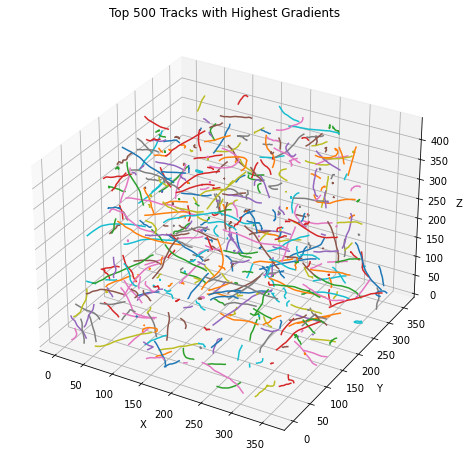

In [124]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

def plot_top_n_gradient_tracks(results, directory_path, n=5):
    """
    Plots the top n tracks with the highest gradients.

    Parameters:
    - results: A numpy array where:
        - Column 0 contains track IDs
        - Column 1 contains gradients
        - Column 2 contains intercepts
    - directory_path: Path to the directory containing track data files.
    - n: Number of tracks to plot (default is 5).
    """
    # Sort results by gradient (column 1) in descending order and take the top n
    sorted_results = results[np.argsort(results[:, 1].astype(float))[::-1]]
    top_n_tracks = sorted_results[:n]

    # Initialize 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Loop through the top n tracks and plot each
    for track in top_n_tracks:
        track_id = track[0]
        gradient = track[1]
        file_name = f"{track_id}.txt"  # Assuming track IDs match file names
        file_path = os.path.join(directory_path, file_name)

        # Load track data
        data = pd.read_csv(
            file_path,
            delim_whitespace=True,
            header=None,
            names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth']
        )

        # Extract smoothed coordinates
        x, y, z = data['x_smooth'], data['y_smooth'], data['z_smooth']

        # Plot track
        ax.plot(x, y, z, label=f'Track {track_id} (Gradient: {float(gradient):.2f})')

    # Configure plot labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Top {n} Tracks with Highest Gradients')

    plt.show()


directory_path = "FINALDATA/WT_planktonic_final/"  # Replace with your directory path
plot_top_n_gradient_tracks(results_with_trackid, directory_path, n=500)


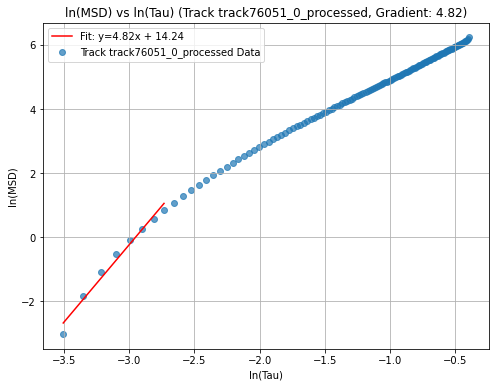

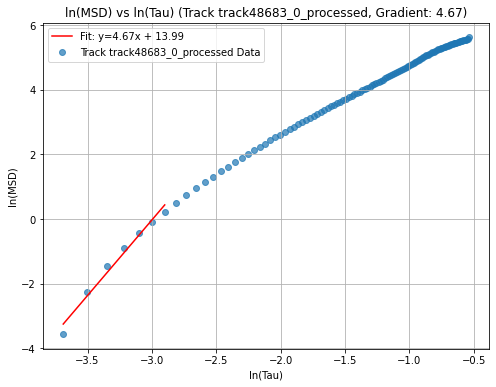

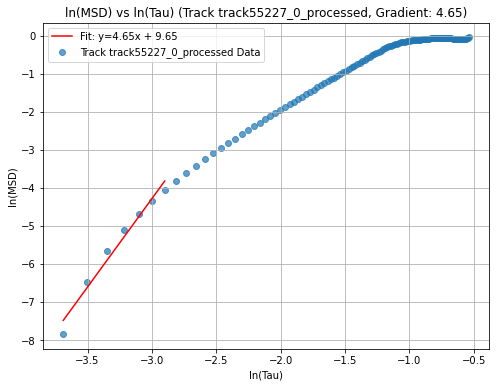

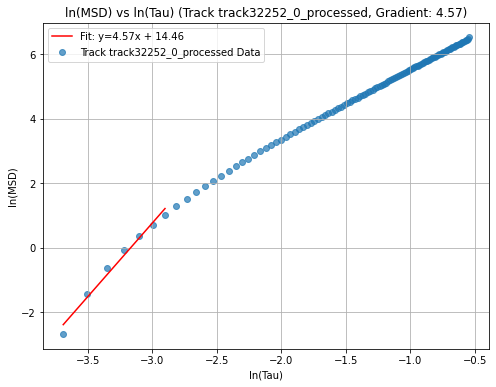

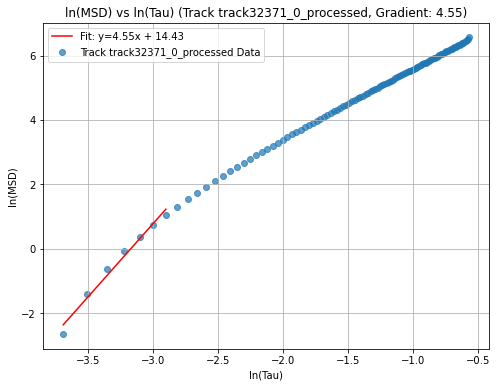

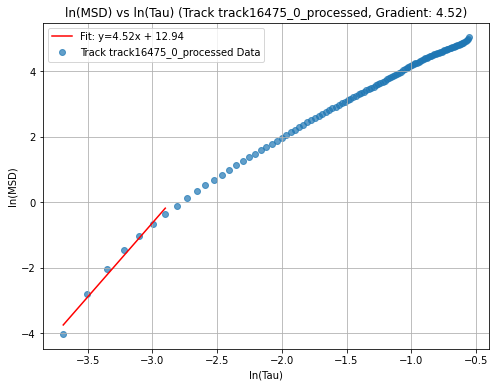

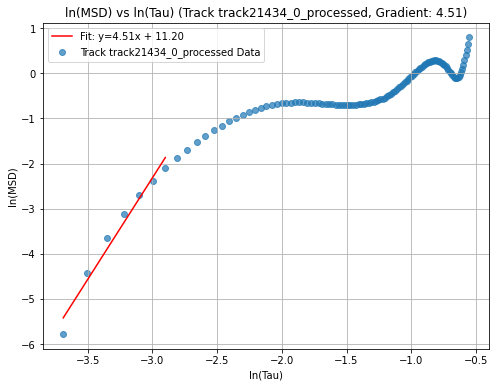

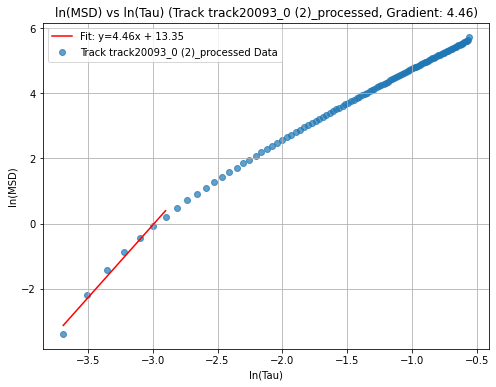

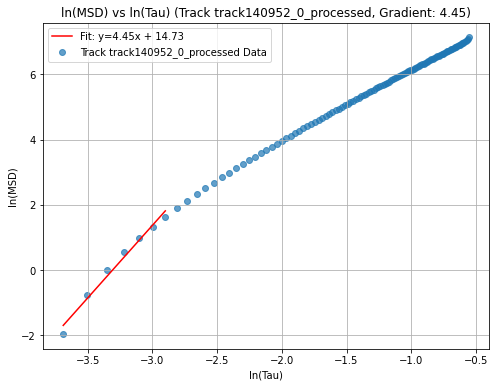

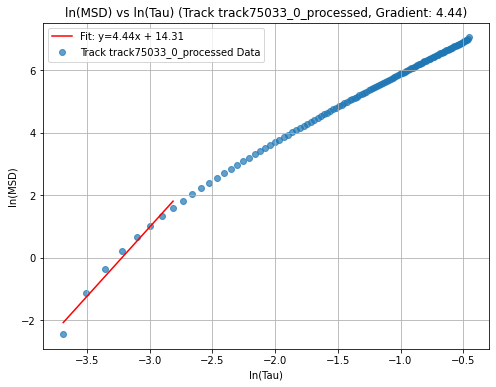

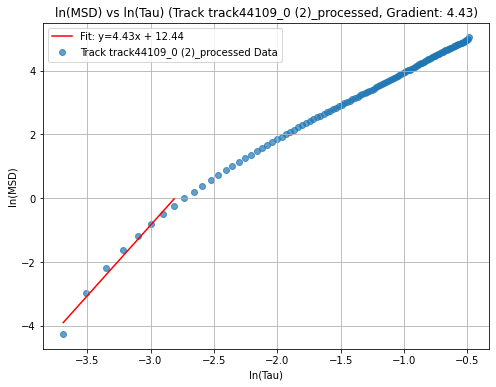

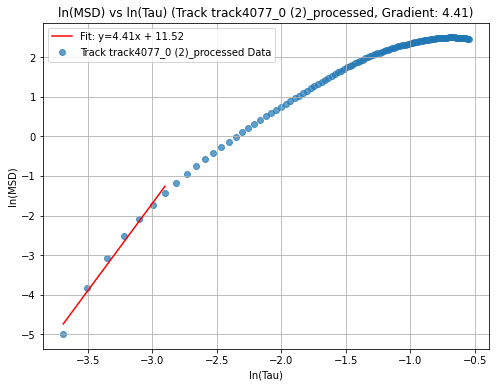

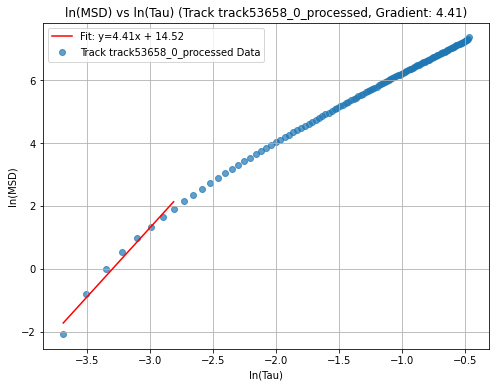

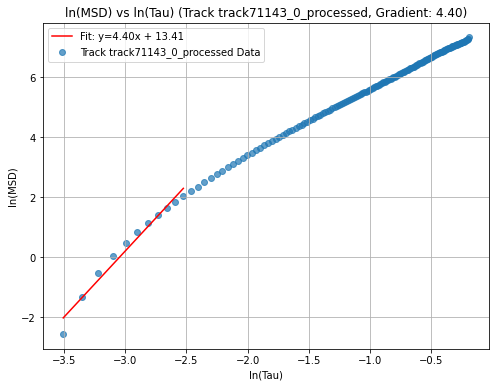

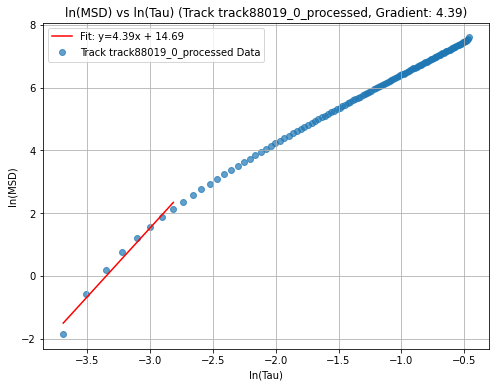

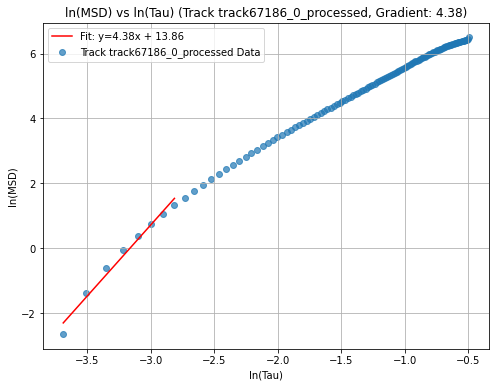

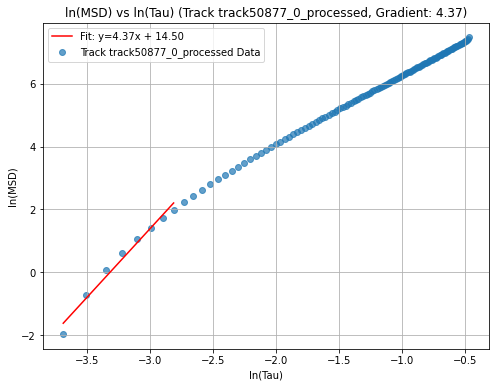

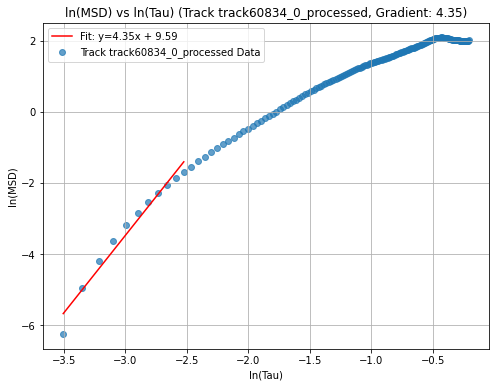

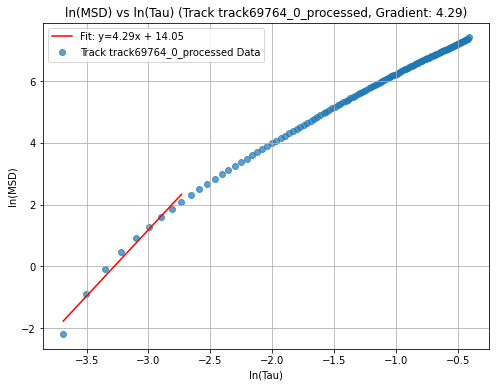

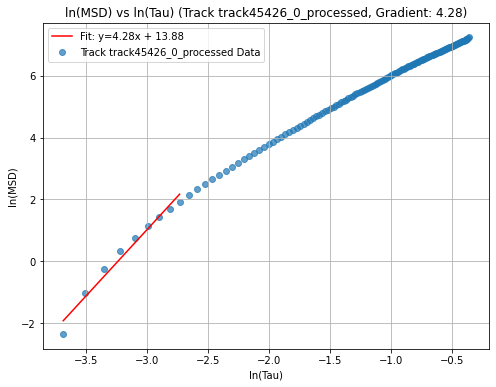

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress

def plot_lnmsd_vs_lntau_top_tracks(results, directory_path, n=5):
    """
    Plots the ln(MSD) vs. ln(tau) for the top n tracks with the highest gradients.

    Parameters:
    - results: A numpy array where:
        - Column 0 contains track IDs
        - Column 1 contains gradients
        - Column 2 contains intercepts
    - directory_path: Path to the directory containing track data files.
    - n: Number of tracks to plot (default is 5).
    """
    # Sort results by gradient (column 1) in descending order and take the top n
    sorted_results = results[np.argsort(results[:, 1].astype(float))[::-1]]
    top_n_tracks = sorted_results[:n]

    # Loop through the top n tracks and plot each
    for track in top_n_tracks:
        track_id = track[0]
        gradient = track[1]
        file_name = f"{track_id}.txt"  # Assuming track IDs match file names
        file_path = os.path.join(directory_path, file_name)

        # Compute MSD and tau using your function
        msd_by_tau = mean_squared_displacement_optimised(file_path)  # Replace with your implementation
        tau_arr = np.array(list(msd_by_tau.keys()))
        msd_arr = np.array(list(msd_by_tau.values()))

        # Take logs of tau and MSD
        log_tau = np.log(tau_arr)
        log_msd = np.log(msd_arr)

        # Determine the cutoff for up to a tenth of tau max
        cutoff_index = tau_arr <= 0.1 * tau_arr.max()
        subset_log_tau = log_tau[cutoff_index]
        subset_log_msd = log_msd[cutoff_index]

        # Perform linear regression on the subset of data
        slope, intercept, r_value, p_value, std_err = linregress(subset_log_tau, subset_log_msd)

        # Generate the regression line
        regression_line = slope * subset_log_tau + intercept

        # Plot the data and regression line
        plt.figure(figsize=(8, 6))
        plt.scatter(log_tau, log_msd, label=f'Track {track_id} Data', alpha=0.7)
        plt.plot(subset_log_tau, regression_line, color='red', label=f'Fit: y={slope:.2f}x + {intercept:.2f}')
        plt.xlabel('ln(Tau)')
        plt.ylabel('ln(MSD)')
        plt.title(f'ln(MSD) vs ln(Tau) (Track {track_id}, Gradient: {float(gradient):.2f})')
        plt.grid()
        plt.legend()
        plt.show()


directory_path = "FINALDATA/WT_planktonic_final/"  # Replace with your directory path
plot_lnmsd_vs_lntau_top_tracks(results_with_trackid, directory_path, n=20)



In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

def check_msd_tau_relationship(file_path):
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                       names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    
    x_smooth = np.array(data['x_smooth'])
    y_smooth = np.array(data['y_smooth'])
    z_smooth = np.array(data['z_smooth'])
    time = np.array(data['time'])
    
    msd_by_tau = {}

    for tau in range(1, len(time)):
        dx = x_smooth[tau:] - x_smooth[:-tau]
        dy = y_smooth[tau:] - y_smooth[:-tau]
        dz = z_smooth[tau:] - z_smooth[:-tau]
        squared_displacements = dx**2 + dy**2 + dz**2
        msd_by_tau[time[tau] - time[0]] = np.mean(squared_displacements)

    tau_arr = np.array(list(msd_by_tau.keys()))
    msd_arr = np.array(list(msd_by_tau.values()))

    # Log-transform the data
    log_tau = np.log(tau_arr)
    log_msd = np.log(msd_arr)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(log_tau, log_msd)

    # Plot the data and regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(log_tau, log_msd, label='Data', alpha=0.7)
    plt.plot(log_tau, slope * log_tau + intercept, color='red', label=f'Fit: y={slope:.2f}x + {intercept:.2f}')
    plt.xlabel('ln(Tau)')
    plt.ylabel('ln(MSD)')
    plt.title(f'ln(MSD) vs ln(Tau)\nSlope: {slope:.2f}')
    plt.grid()
    plt.legend()
    plt.show()

    print(f"Slope: {slope}")
    print(f"R-squared: {r_value**2}")
    return slope


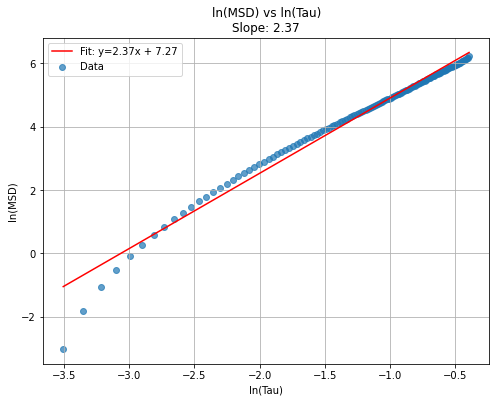

Slope: 2.3727297083656897
R-squared: 0.9781143005966869


2.3727297083656897

In [139]:
check_msd_tau_relationship('FINALDATA/WT_planktonic_final/track76051_0_processed.txt')

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

def analyze_two_regions(file_path):
    # Compute MSD and tau
   
    data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['time', 'x', 'y', 'z', 'x_smooth', 'y_smooth', 'z_smooth'])
    x_smooth = data['x_smooth']
    y_smooth = data['y_smooth']
    z_smooth = data['z_smooth']
    time = data['time']
    msd_by_tau = mean_squared_displacement_optimised(file_path)
    tau_arr = np.array(list(msd_by_tau.keys()))
    msd_arr = np.array(list(msd_by_tau.values()))

    # Log-transform data
    log_tau = np.log(tau_arr)
    log_msd = np.log(msd_arr)

    # Define a breakpoint (can also be determined dynamically)
    breakpoint = tau_arr.max() / 10  
    region1_mask = tau_arr <= breakpoint
    region2_mask = tau_arr > breakpoint

    # Split into two regions
    log_tau_region1 = log_tau[region1_mask]
    log_msd_region1 = log_msd[region1_mask]
    log_tau_region2 = log_tau[region2_mask]
    log_msd_region2 = log_msd[region2_mask]

    # Fit each region
    slope1, intercept1, _, _, _ = linregress(log_tau_region1, log_msd_region1)
    slope2, intercept2, _, _, _ = linregress(log_tau_region2, log_msd_region2)

    # Plot both regions with their regression lines
    plt.figure(figsize=(10, 6))
    plt.scatter(log_tau, log_msd, label='Data', alpha=0.5)
    plt.plot(log_tau_region1, slope1 * log_tau_region1 + intercept1, color='red', label=f'Region 1: y={slope1:.2f}x + {intercept1:.2f}')
    plt.plot(log_tau_region2, slope2 * log_tau_region2 + intercept2, color='blue', label=f'Region 2: y={slope2:.2f}x + {intercept2:.2f}')
    plt.xlabel('ln(Tau)')
    plt.ylabel('ln(MSD)')
    plt.title('Two Linear Regions in ln(MSD) vs ln(Tau)')
    plt.legend()
    plt.savefig('FINALDATA/Plots/two_mode_example')
    plt.grid()
    plt.show()
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.grid

    ax.scatter3D(x_smooth, y_smooth, z_smooth)
    ax.set_title('Test Plot WT_planktonic Track1_0')
    ax.set_xlabel('x(µm)')
    ax.set_ylabel('y(µm)')
    ax.set_zlabel('z(µm)')
    
    plt.show()

    return slope1, intercept1, slope2, intercept2


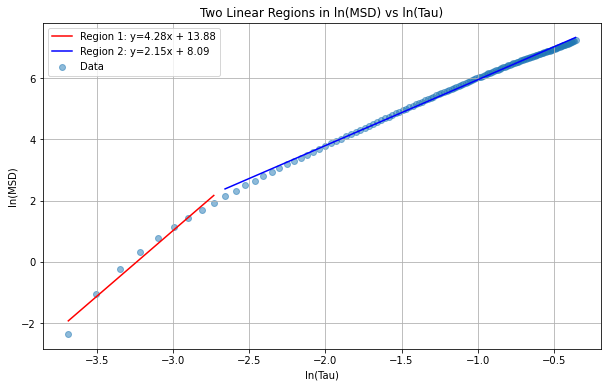

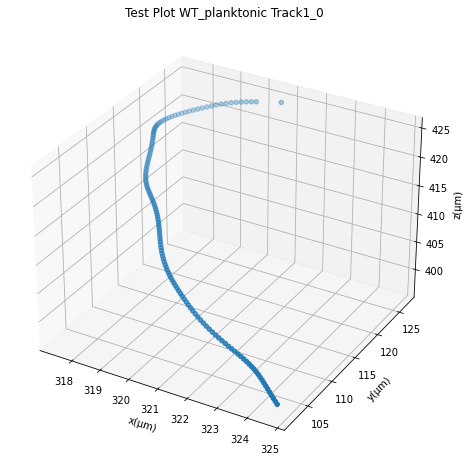

(4.284701400693386, 13.881535607542899, 2.147627328283767, 8.094386701167135)

In [166]:
analyze_two_regions('FINALDATA/WT_planktonic_final/track45426_0_processed.txt')

In [159]:
import shutil
import os

def sort_directory2(directory_path, output_base):
    """
    Sorts files based on the slope calculated from find_gradient_intercept.
    
    - Files with slope between 1.75 and 2.1 are considered "in range" and are copied to `tracks_in_range`.
    - Files with slope below 1.75 are considered "out of range" and are copied to `tracks_out_range`.
    - Files with slope above 2.1 are not copied.

    Parameters:
    - directory_path: Path to the directory containing input files.
    - output_base: Path to the base output directory.
    """
    # Create output directories
    in_range_dir = os.path.join(output_base, "EDS")
    out_range_dir = os.path.join(output_base, "EDNS")
    os.makedirs(in_range_dir, exist_ok=True)
    os.makedirs(out_range_dir, exist_ok=True)
    
    # Get all text files in the input directory
    files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.txt')]
    
    for file_path in files:
        # Calculate slope and intercept
        slope, intercept = find_gradient_intercept(file_path)
        
        # Determine the appropriate action based on the slope
        if 1.75 <= slope <= 2.1:
            target_dir = in_range_dir
            shutil.copy(file_path, target_dir)
        elif slope < 1.75:
            target_dir = out_range_dir
            shutil.copy(file_path, target_dir)
        # If slope > 2.1, do not copy the file
    
    print(f"Tracks with slope between 1.75 and 2.1 copied to {in_range_dir}")
    print(f"Tracks with slope below 1.75 copied to {out_range_dir}")
    print("Tracks with slope above 2.1 were not copied.")


sort_directory2('FINALDATA/evolved+disk_planktonic_final/', "FINALDATA/Split_Data/Evolved+disk//")


<ipython-input-87-6691b6bff159>:49: RuntimeWarning:

divide by zero encountered in log

/Users/ethanbrentnall/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2699: RuntimeWarning:

invalid value encountered in subtract



Tracks with slope between 1.75 and 2.1 copied to FINALDATA/Split_Data/Evolved+disk//EDS
Tracks with slope below 1.75 copied to FINALDATA/Split_Data/Evolved+disk//EDNS
Tracks with slope above 2.1 were not copied.
